### ANÁLISE DOS DADOS

---
Nessa etapa de exploração da série buscamos identificar tendência , sazonalidades , estacionariedade para definir insumos corretos para modelagem,
também criamos baselines simples para comparação futura.

Essa etapa foi fundamental para verificar que a série náo era estacionária foi preciso usar transformação logaritmica para reduzir
a variÂncia da série assim como aplicar a diferrenciação para tornar a série estacionária. Foi possivel observar uma tendÊncia clara na série e definir
os paramÊtros do modelo através da análise gráfica de autocorrelação.


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### BASE DE DADOS

---



In [ ]:
df = pd.read_csv("vendas_diarias.csv", parse_dates=["data"])

In [ ]:
df.head(5)

,data,receita_diaria,qtd_diaria,ano,mes,dia_semana,fim_de_semana
0,2011-01-01,7156.5400,2.0,2011,1,5,1
1,2011-01-02,15012.1782,5.0,2011,1,6,1
2,2011-01-03,14313.0800,4.0,2011,1,0,0
3,2011-01-04,7855.6382,3.0,2011,1,1,0
4,2011-01-05,7855.6382,3.0,2011,1,2,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1035 entries, 0 to 1034
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   data            1035 non-null   datetime64[ns]
 1   receita_diaria  1035 non-null   float64       
 2   qtd_diaria      1035 non-null   float64       
 3   ano             1035 non-null   int64         
 4   mes             1035 non-null   int64         
 5   dia_semana      1035 non-null   int64         
 6   fim_de_semana   1035 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 56.7 KB


### MEDIDAS DESCRITIVAS

---



In [ ]:
df.describe()

,data,receita_diaria,qtd_diaria,ano,mes,dia_semana,fim_de_semana
count,1035,1035.000000,1035.000000,1035.000000,1035.000000,1035.000000,1035.000000
mean,2012-06-01 00:00:00,24748.097695,46.057971,2011.941063,6.228019,2.999034,0.285990
min,2011-01-01 00:00:00,0.000000,0.000000,2011.000000,1.000000,0.000000,0.000000
25%,2011-09-16 12:00:00,14054.324950,6.000000,2011.000000,3.000000,1.000000,0.000000
50%,2012-06-01 00:00:00,20937.486400,9.000000,2012.000000,6.000000,3.000000,0.000000
75%,2013-02-14 12:00:00,32296.184100,103.500000,2013.000000,9.000000,5.000000,1.000000
max,2013-10-31 00:00:00,82428.380000,246.000000,2013.000000,12.000000,6.000000,1.000000
std,NaN,14953.146424,63.584183,0.802200,3.322770,2.001692,0.452103


Através das medidas descitivas podemos notar que a receita possui alta variância
, muitos dias com valor zero o que é um indício forte de não estacionariedade. Vamos fazer uma análise mais profunda dos dados para verificar .

### VISUALIZAÇÃO

---



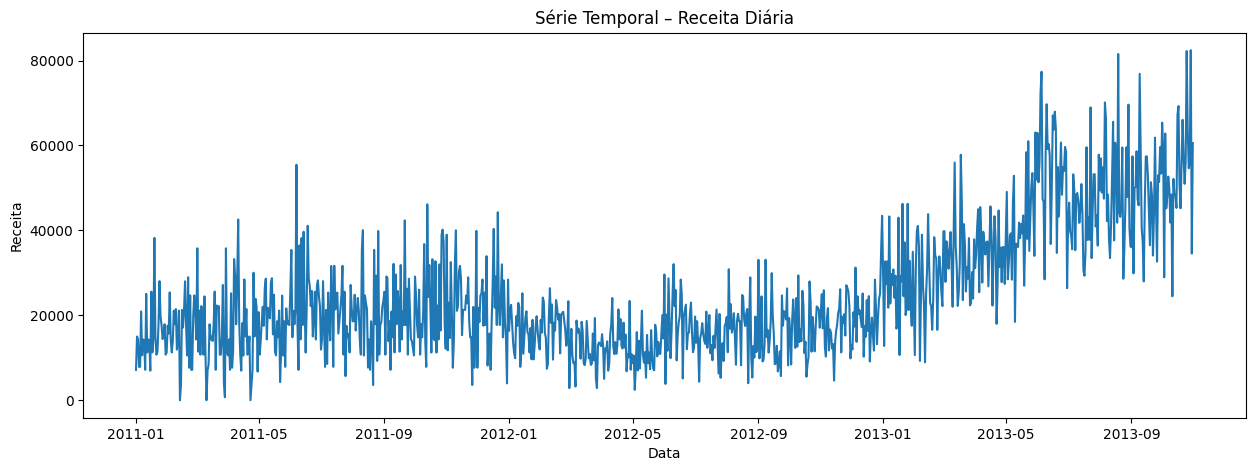

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(df["data"], df["receita_diaria"])
plt.title("Série Temporal – Receita Diária")
plt.xlabel("Data")
plt.ylabel("Receita")
plt.show()

Observamos uma tendência crescente ao longo dos anos com picos concentrados eventos / promoções e variância não constante. Utilizaremos log para estabilizar a variância.

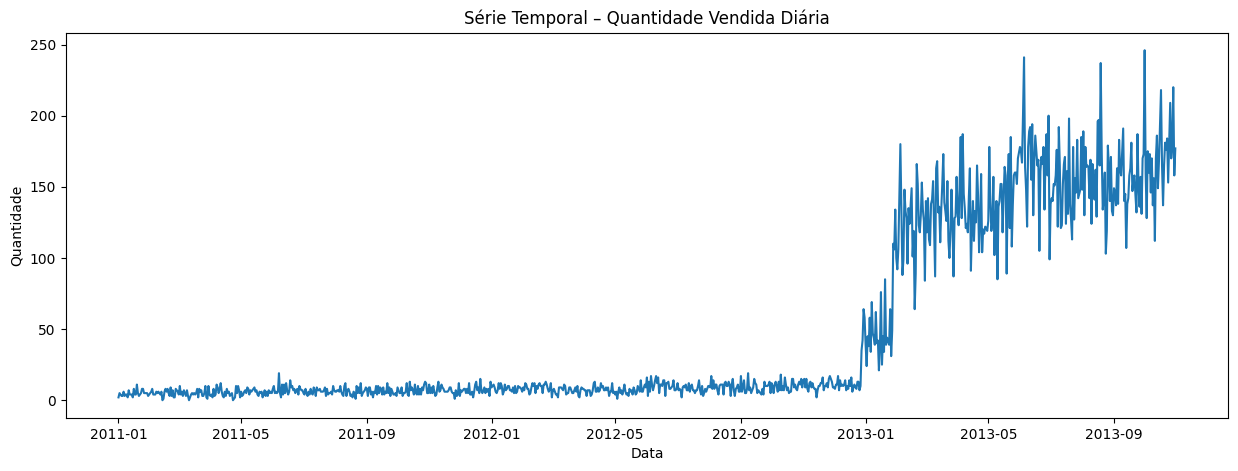

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(df["data"], df["qtd_diaria"])
plt.title("Série Temporal – Quantidade Vendida Diária")
plt.xlabel("Data")
plt.ylabel("Quantidade")
plt.show()

Quantidade vendida diária segue padrão similar.

### AGRUPANDO A RECEITA POR MêS E POR DIA DA SEMANA

---



In [ ]:
df["dia_semana_nome"] = df["data"].dt.day_name()

media_semana = (
    df.groupby("dia_semana_nome")["receita_diaria"]
    .mean()
    .reindex([
        "Monday", "Tuesday", "Wednesday",
        "Thursday", "Friday", "Saturday", "Sunday"
    ])
)



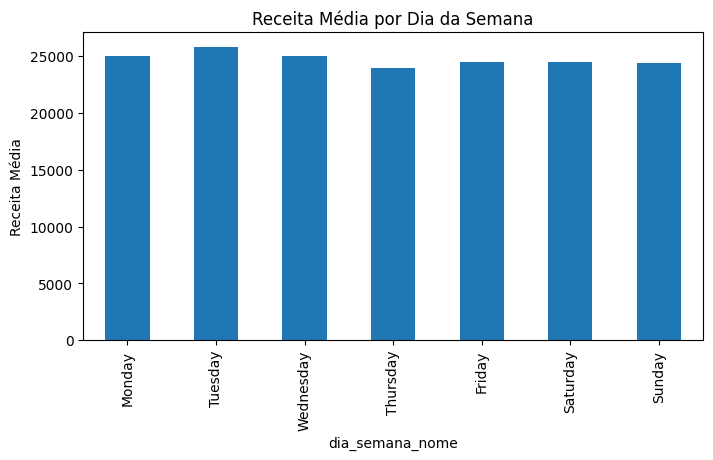

In [ ]:
media_semana.plot(kind="bar", figsize=(8,4))
plt.title("Receita Média por Dia da Semana")
plt.ylabel("Receita Média")
plt.show()

A sazonalidade semanal fica clara e justifica variável exógena **dia_semana**

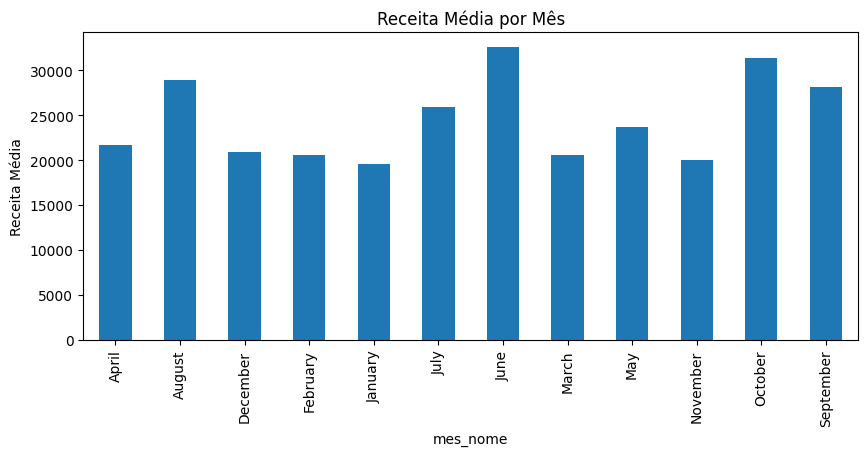

In [ ]:
df["mes_nome"] = df["data"].dt.month_name()

media_mes = (
    df.groupby("mes_nome")["receita_diaria"]
    .mean()
)

media_mes.plot(kind="bar", figsize=(10,4))
plt.title("Receita Média por Mês")
plt.ylabel("Receita Média")
plt.show()

Indícios também de sazonalidade anual , portanto o SARIMAX é adequado.

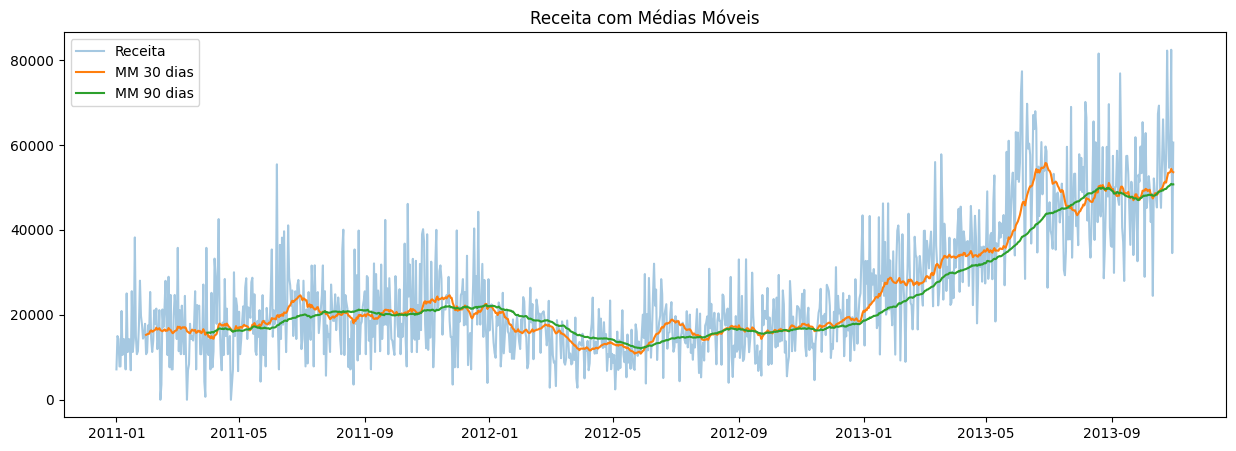

In [ ]:
df["mm_30"] = df["receita_diaria"].rolling(30).mean()
df["mm_90"] = df["receita_diaria"].rolling(90).mean()

plt.figure(figsize=(15,5))
plt.plot(df["data"], df["receita_diaria"], alpha=0.4, label="Receita")
plt.plot(df["data"], df["mm_30"], label="MM 30 dias")
plt.plot(df["data"], df["mm_90"], label="MM 90 dias")
plt.legend()
plt.title("Receita com Médias Móveis")
plt.show()

Tendência clara a  **série não é estacionária**.

## TESTES ESTATÍSTICOS

---



In [ ]:
### Função teste de estacionariedade (ADF)

def adf_test(series, title=""):
    result = adfuller(series)
    print(f"ADF Test: {title}")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print("-" * 40)

In [ ]:
adf_test(df["receita_diaria"], "Receita Diária")

ADF Test: Receita Diária
ADF Statistic: -0.5939
p-value: 0.8724
----------------------------------------


p-value > 0.05 , ou seja , a série  **não é estacionária**

TRANSFORMAÇÃO LOGARITIMICA

---



In [ ]:
df["receita_log"] = np.log1p(df["receita_diaria"])


In [ ]:
adf_test(df["receita_log"], "Receita Log")

ADF Test: Receita Log
ADF Statistic: -2.1342
p-value: 0.2310
----------------------------------------


Log reduz variância, mas ainda pode precisa de  diferenciação para deixar a série estacionária .

In [ ]:
df["receita_log_diff"] = df["receita_log"].diff().dropna() #diferenciação da série

In [ ]:
adf_test(df["receita_log_diff"].dropna(), "Receita Log Diferenciada")

ADF Test: Receita Log Diferenciada
ADF Statistic: -11.7507
p-value: 0.0000
----------------------------------------


 Com o log + diferenciação a série está estacionária e a base está apta  para SARIMAX

### GRÁFICOS AUTOCORRELAÇÃO

---
Definir parametros p, d, q  (P, D, Q) sazonalidade semanal (s=7)

<Figure size 1200x400 with 0 Axes>

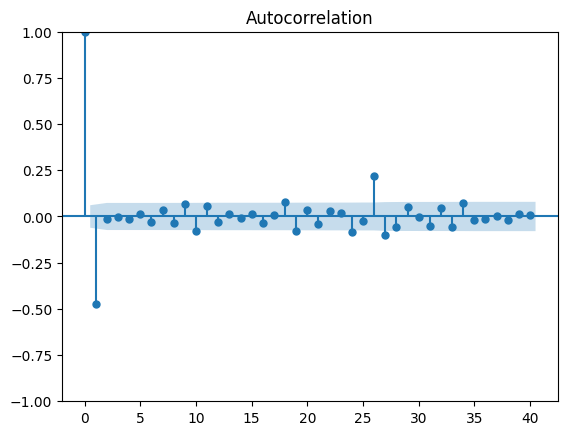

In [ ]:
plt.figure(figsize=(12,4))
plot_acf(df["receita_log_diff"].dropna(), lags=40)
plt.show()

<Figure size 1200x400 with 0 Axes>

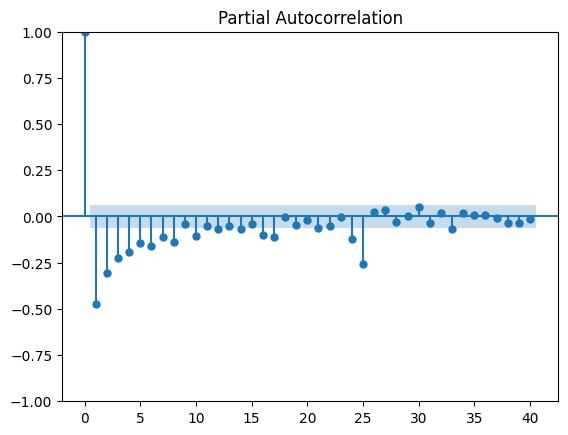

In [ ]:
plt.figure(figsize=(12,4))
plot_pacf(df["receita_log_diff"].dropna(), lags=40)
plt.show()



*  O ACF apresenta um pico significativo no lag 1, seguido por valores próximos de zero dentro do intervalo de confiança , caracterizando um processo MA de curta ordem, um pico isolado no lag 1 do ACF sugere o termo  MA(1) q = 1.




*  O PACF mostra significância nos primeiros lags  lag 1 e lag 2 após o segundo lag, os coeficientes decaem gradualmente e permanecem próximos de zero, ou seja,  dependência direta da série ocorre até aproximadamente o lag 2, sugerindo um AR(2) o termo p = 2.




*  Baseado na estacionariedade a série original apresentava tendênci após a diferenciação de ordem 1 conseguimos estabilizar a média e variância ,autocorrelações não persistem ao longo dos lags. d = 1 é suficiente, não sendo necessária mais diferenciação.





### BASELINES

---


Os baselines serão usados para comparação de erro e validação real do modelo.

In [ ]:
# Naive (último valor)

df["baseline_naive"] = df["receita_diaria"].shift(1)

In [ ]:
# Média móvel 7 dias
df["baseline_mm7"] = df["receita_diaria"].rolling(7).mean().shift(1)